# Step-1:Importing all modules

In [1]:
from pandas import read_csv
import pandas as pd
import numpy as np
from string import punctuation
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

[nltk_data] Downloading package stopwords to C:\Users\Rahul
[nltk_data]     Gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Rahul
[nltk_data]     Gupta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Step-2: Loading the dataset

In [3]:
df = read_csv("train.csv")
df = df.drop(['id', 'title', 'author'],axis = 1)

# Step-3: Cleaning the data

In [4]:
# filling na with space
df['text'] = df['text'].fillna(' ')
# removing the urls from the test
df['text'] = df['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
# removing @ user references and # hashtags from text
df['text'] = df['text'].str.replace(r'\@\w+|\#\w+','', regex=True)
# removing the special characters & lowercasing the string
df['text'] = df['text'].apply(lambda x: ''.join(i.lower() for i in x if i not in punctuation ))
# removing the numbers
df['text'] = df['text'].str.replace('d', '', regex=True)

# Visualization

<AxesSubplot:xlabel='label', ylabel='count'>

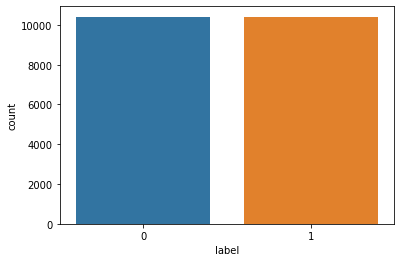

In [5]:
sns.countplot(x ='label', data = df)

# Step-4: Data processing

In [6]:

ps = PorterStemmer()
stop_words = stopwords.words("english")
# removing stopwords in sentences & stemming each word
sentence_list = list(map(lambda x: "". join(ps.stem(word) for word in x if word not in stop_words), df['text'].values))
# encoding sentences into integer representation
encoded_sentences = [one_hot(sentence, 5000) for sentence in sentence_list]
# padding sequences for getting same length list 
sent_list = pad_sequences(encoded_sentences, maxlen=20, padding='pre')

X = np.array(sent_list)
y = np.array(df['label'])

# splitting the data for train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


# Step-5: Model lifecycle

In [7]:
# model creation
model=Sequential()
model.add(Embedding(5000, 40, input_length=20))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1,activation='sigmoid'))

#model compilation
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

model_dump = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64)

#saving model
model.save("model.h5", model_dump)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
228/228 [==============================] - 19s 55ms/step - loss: 0.4069 - accuracy: 0.7898 - val_loss: 0.3464 - val_accuracy: 0.8381
Epoch 2/20
228/228 [==============================] - 11s 47ms/step - loss: 0.2692 - accuracy: 0.88

# Predict example

In [11]:
sentence = "There is a rise in the positive cases for covid"

data = []
review = re.sub('[^a-zA-Z]', ' ', sentence)
review = review.lower()
review = review.split()
review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
review = ' '.join(review)
data.append(review)

onehot_t = [one_hot(words, 5000) for words in data]
docs = pad_sequences(onehot_t, padding = "pre", maxlen=20)

predict_list = np.array(docs)

THRESHOLD = 0.5

if model.predict(predict_list)[0][0] > THRESHOLD:
    print("REAL")
else:
    print("FAKE")

REAL
